# Limpiar Base de Datos Nacional

El objetivo de este cuaderno es poder limpiar la base de Datos Nacional del **INS** (Instituto Nacional de Salud) diariamente para consolidarla posteriormente con la base de Muestras Procesadas y así generar una base de datos histórica que permita llevar un seguimiento a las tendencias de cada uno de los pacientes dentro del marco de la epidemia. 

Este análisis es de suma importancia para generar proyecciones valiosas frente al comportamiento del virus en el país y el número de camas UCI necesarias para salvar tantas vidas como sea posible.

Los Conjuntos de Datos asociados pueden encontrarse en:

- [Base Nacional del INS COVID-19 en Colombia](https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr)

- [Muestras Procesadas de COVID-19 en Colombia](https://www.datos.gov.co/Salud-y-Protecci-n-Social/Muestras-procesadas-de-COVID-19-en-Colombia/8835-5baf)

**Esta limpieza y rutinas está sujeta cambios en cuanto a la presentación de la información por parte del INS**.

Para acceder a las **bases históricas**, se puede acceder a:

- [Base Nacional Histórico](https://www.ins.gov.co/Paginas/Boletines-casos-COVID-19-Colombia.aspx)

# Librerías Necesarias

(Justificación de las librerías es obvio, pero toca dar una pequeña descripción)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.optimize import curve_fit
from datetime import timedelta,date,datetime

# Rutinas Para Cambio de Fechas

Un ejemplo de tipo de fecha es **2020-03-02T00:00:00.000**, lo cual no es muy útil al momento de visualizar los datos, pues esto genera contaminación visual y se hace innecesario tenerlo en una base unificada y diciente. 

No sabemos si es importante el registro de las horas del resultado de la prueba además de un tentativo análisis sobre la cuantificación de **eficiencia** en el registro de salud de cada uno de los entes involucrados.

Por lo que resta del estudio, asumiremos que esto no es tan importante (que sí lo es) para el análisis del virus y su evolución en la población colombiana.

Por esta razón, eliminaremos dichas horas para dejar sólo el año, el día y el mes asociado a cada caso.

In [2]:
def NormalFecha(fecha):
    try:
        '''
        if len(fecha) == 10: # Por si hay fechas tipo 2020/07/06
            fecha = fecha.replace('/','-')
            fecha=fecha.split('-')
            fecha = fecha[2] + '-' + fecha[1]+'-'+ fecha[0]
        else:
        '''
            # Haga el split adecuado
        fecha = fecha.split('T')[0].split('-')
        if len(fecha) == 3:
            fecha = fecha[0] + '-' + fecha[1]+'-'+ fecha[2]
        else:
            fecha = 'NaN'
        # Cambiaron 'SIN DATO' a una fecha       
        #if fecha=='1899-12-31': # 2020-07-06
        if fecha=='SIN DATO':
            fecha = 'NaN'
            
    except IndexError:
        fecha = 'NaN'
    return fecha

In [3]:
def Fechas_Neg(fecha):
    if len(fecha)>=11:
        fecha=str(fecha).split('\n')[0].split('days')[0]
        fecha=fecha.split('+')[0]
        fecha=float(fecha)
    return fecha

# Leer Datos y Limpieza Inicial

Como nuestra idea es consolidar todos los boletines históricos en una gran base de datos coherente, mientras se realiza una posible automatización del proceso, haremos el análisis manualmente, indicando cada fecha usada.

In [4]:
# Leer Datos
fecha_pura=date.today()+timedelta(days=-1)
fecha = str(fecha_pura)
print("Fecha Boletín:",fecha)
datos=pd.read_csv('../Datos/'+fecha+'.csv',low_memory=False)
#Boletines Históricos
#datos=pd.read_excel('../Datos/Nacionales/Datos_C_'+fecha+'.xlsx')

Fecha Boletín: 2020-09-11


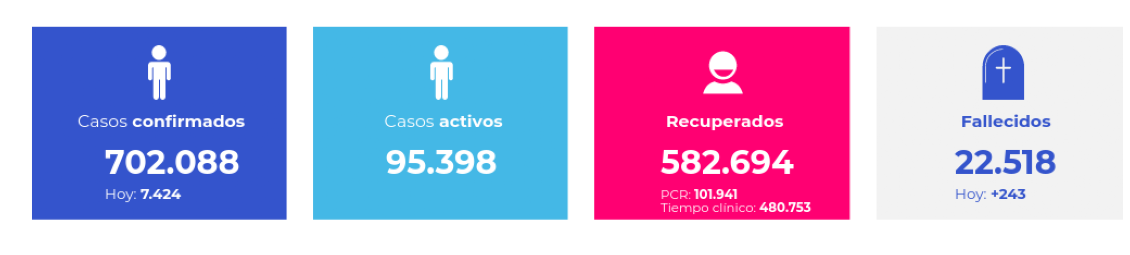

In [5]:
img = mpimg.imread('../Imagenes/pandas_'+fecha+'.png')

plt.figure(figsize=(20,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
datos_todo=len(datos)
print("Observaciones Totales:", datos_todo,'\n')
print(datos.columns.values)

Observaciones Totales: 702088 

['ID de caso' 'Fecha de notificación' 'Código DIVIPOLA'
 'Ciudad de ubicación' 'Departamento o Distrito ' 'atención' 'Edad' 'Sexo'
 'Tipo' 'Estado' 'País de procedencia' 'FIS' 'Fecha de muerte'
 'Fecha diagnostico' 'Fecha recuperado' 'fecha reporte web'
 'Tipo recuperación' 'Codigo departamento' 'Codigo pais'
 'Pertenencia etnica' 'Nombre grupo etnico']


Como podemos observar, el dato registrado en **Observaciones Totales** coincide con el dato en internet registrado tanto en Google como en el INS **a la fecha**:

- [INS](http://www.ins.gov.co/Noticias/Paginas/Coronavirus.aspx)
- [Google](https://news.google.com/covid19/map?hl=es-419&mid=/m/01ls2&gl=CO&ceid=CO:es-419)

**Es importante hacer ésta rutina diaria para verificar inconsistencias en cómo se muestra la información en los medios de comunicación y en internet**.

# Renombrar Columnas Para Fácil Acceso de los Datos 

Una de las grandes características de Pandas es su flexibilidad para acceder a los datos con notaación punto y notación posicional.
En el primer caso, si queremos usar un autocompletado eficiente, deberemos llamar las columnas de manera adecuada.

In [7]:
# Hacer Nombres Eficientes (En tu cara Colombia)

renombrar_columns= ['ID_caso', 'Fecha_notificacion', 'DIVIPOLA',
 'Ciudad', 'Departamento_Distrito', 'Atencion', 'Edad', 'Sexo',
 'Tipo_caso', 'Estado', 'Pais_procedencia', 'Fecha_inicio_sintoma', 'Fecha_muerte',
 'Fecha_diagnostico', 'Fecha_recuperado', 'Fecha_web',
 'Tipo_recuperacion', 'Codigo_departamento', 'Codigo_pais',
 'Pertenencia_etnica','Nombre_etnia'] # Nombre_etnia Agregado 2020-06-24

datos.columns=renombrar_columns

# Re-ordenar Nombres Para Facilitar lectura por inspección

reordenar= ['ID_caso', 'Fecha_inicio_sintoma', 'Fecha_notificacion', 'Fecha_diagnostico','Fecha_recuperado','Fecha_muerte','Fecha_web',
             'Estado','Atencion','Tipo_recuperacion','Ciudad','DIVIPOLA','Departamento_Distrito','Codigo_departamento', 'Edad', 'Sexo','Tipo_caso', 
            'Pais_procedencia', 'Codigo_pais','Pertenencia_etnica','Nombre_etnia']

# Re-ordenar Columnas

datos = datos[reordenar]

# Revisar Cambios Abruptos de Fechas 

In [8]:
#print(datos.Fecha_notificacion.unique()) # Cambian día a día el formato de las fechas
#print(datos.Fecha_diagnostico.unique()) # Hay bastantes diferencias en el formato de Fechas
#print(datos.Fecha_inicio_sintoma.unique())
#print(datos.Fecha_muerte.unique())
#print(datos.Fecha_recuperado.unique())

# Revisar Cambios Abruptos de Fechas 

In [9]:
print("Variables Colombia:\n\n",datos.columns.values,'\n')
print("Atención:\n\n",datos["Atencion"].unique(),'\n')
print("Estado:\n\n",datos["Estado"].unique(),'\n')

Variables Colombia:

 ['ID_caso' 'Fecha_inicio_sintoma' 'Fecha_notificacion' 'Fecha_diagnostico'
 'Fecha_recuperado' 'Fecha_muerte' 'Fecha_web' 'Estado' 'Atencion'
 'Tipo_recuperacion' 'Ciudad' 'DIVIPOLA' 'Departamento_Distrito'
 'Codigo_departamento' 'Edad' 'Sexo' 'Tipo_caso' 'Pais_procedencia'
 'Codigo_pais' 'Pertenencia_etnica' 'Nombre_etnia'] 

Atención:

 ['Recuperado' 'Fallecido' nan 'Hospital UCI' 'Casa' 'Hospital'] 

Estado:

 ['Leve' 'Asintomático' 'Fallecido' 'Moderado' nan 'Grave'] 



# Convertir Fechas (No importa la hora de registro)

En este punto, como no hay horas distintas registradas en los registros (Todas se registran medicamente al mismo tiempo), no es necesario tener en cuenta tal información.

In [10]:
#Convertir  Fechas a strings
datos['Fecha_inicio_sintoma']=datos['Fecha_inicio_sintoma'].astype('str')
datos['Fecha_notificacion']=datos['Fecha_notificacion'].astype('str')
datos['Fecha_diagnostico']=datos['Fecha_diagnostico'].astype('str')
datos['Fecha_muerte']=datos['Fecha_muerte'].astype('str')
datos['Fecha_recuperado']=datos['Fecha_recuperado'].astype('str')
datos['Fecha_muerte']=datos['Fecha_muerte'].astype('str')
datos['Fecha_web']=datos['Fecha_web'].astype('str')

#Limpiar Fechas
datos['Fecha_inicio_sintoma']=datos['Fecha_inicio_sintoma'].apply(lambda fecha: NormalFecha(fecha))
datos['Fecha_notificacion']=datos['Fecha_notificacion'].apply(lambda fecha: NormalFecha(fecha))
datos['Fecha_diagnostico']=datos['Fecha_diagnostico'].apply(lambda fecha: NormalFecha(fecha))
datos['Fecha_recuperado']=datos['Fecha_recuperado'].apply(lambda fecha: NormalFecha(fecha))
datos['Fecha_muerte']=datos['Fecha_muerte'].apply(lambda fecha: NormalFecha(fecha))
datos['Fecha_web']=datos['Fecha_web'].apply(lambda fecha: NormalFecha(fecha))

#Filtrar Diagnosticados
#datos_diag=pd.DataFrame(datos[np.logical_and(datos['Fecha_diagnostico']!='SIN DATO',datos['Fecha_diagnostico']!='nan')]) #2020-07-05
#datos_diag=pd.DataFrame(datos[np.logical_and(datos['Fecha_diagnostico']!='1899-12-31T00:00:00.000',datos['Fecha_diagnostico']!='nan')]) # 2020-07-06
datos_diag=pd.DataFrame(datos[datos['Fecha_diagnostico']!='NaN']) #2020-07-07

# Filtrar No Diagnosticados
#datos_nodiag=pd.DataFrame(datos[np.logical_or(datos['Fecha_diagnostico']=='SIN DATO',datos['Fecha_diagnostico']=='nan')]) #2020-07-05
#datos_nodiag=pd.DataFrame(datos[np.logical_or(datos['Fecha_diagnostico']=='1899-12-31T00:00:00.000',datos['Fecha_diagnostico']=='nan')]) # 2020-07-06
datos_nodiag=pd.DataFrame(datos[datos['Fecha_diagnostico']=='NaN']) #2020-07-07

print("\nObservaciones Diagnosticadas   :", len(datos_diag))
print("Observaciones No Diagnosticadas:  ", len(datos_nodiag))
print("Observaciones Totales          :", datos_todo)


Observaciones Diagnosticadas   : 698063
Observaciones No Diagnosticadas:   4025
Observaciones Totales          : 702088


# Casos No Diagnosticados 

In [13]:
datos_nodiag.sample(5)

,ID_caso,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Fecha_web,Estado,Atencion,Tipo_recuperacion,...,DIVIPOLA,Departamento_Distrito,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia
99061,99102,2020-04-30,2020-05-04,NaN,2020-07-02,NaN,2020-07-01,Leve,Recuperado,Tiempo,...,76001,Valle del Cauca,76,70,M,En estudio,NaN,NaN,Otro,NaN
108059,108100,2020-05-15,2020-05-21,NaN,2020-07-04,NaN,2020-07-03,Leve,Recuperado,Tiempo,...,13001,Cartagena D.T. y C.,13,49,M,En estudio,NaN,NaN,Otro,NaN
118560,118601,2020-04-22,2020-05-06,NaN,NaN,2020-05-06,2020-07-06,Fallecido,Fallecido,NaN,...,8433,Atlántico,8,54,F,En estudio,NaN,NaN,Otro,NaN
154798,154839,2020-06-18,2020-07-03,NaN,2020-07-18,NaN,2020-07-14,Leve,Recuperado,Tiempo,...,13001,Cartagena D.T. y C.,13,54,F,En estudio,NaN,NaN,Otro,NaN
148314,148355,2020-04-03,2020-04-15,NaN,2020-07-15,NaN,2020-07-12,Leve,Recuperado,Tiempo,...,8001,Barranquilla D.E.,8,47,F,En estudio,NaN,NaN,Otro,NaN


# Casos Diagnosticados 

In [14]:
datos_diag.sample(5)

,ID_caso,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Fecha_web,Estado,Atencion,Tipo_recuperacion,...,DIVIPOLA,Departamento_Distrito,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia
487951,487992,2020-07-30,2020-08-03,2020-08-14,2020-08-25,NaN,2020-08-18,Leve,Recuperado,Tiempo,...,5001,Antioquia,5,64,F,En estudio,NaN,NaN,Otro,NaN
208638,208679,2020-07-05,2020-07-05,2020-07-20,2020-08-04,NaN,2020-07-21,Leve,Recuperado,Tiempo,...,11001,Bogotá D.C.,11,35,M,En estudio,NaN,NaN,Otro,NaN
509651,509692,2020-08-13,2020-08-15,2020-08-19,2020-09-03,NaN,2020-08-20,Leve,Recuperado,Tiempo,...,11001,Bogotá D.C.,11,38,F,En estudio,NaN,NaN,Otro,NaN
174310,174351,2020-06-18,2020-06-21,2020-07-02,2020-08-26,NaN,2020-07-17,Leve,Recuperado,PCR,...,70001,Sucre,70,26,M,En estudio,NaN,NaN,Otro,NaN
5308,5349,2020-04-16,2020-04-19,2020-04-26,2020-05-04,NaN,2020-04-26,Leve,Recuperado,PCR,...,11001,Bogotá D.C.,11,43,F,Importado,ESPAÑA,724.0,Otro,NaN


# Transformar Fechas a Formato Adecuado

In [15]:
datos['Fecha_inicio_sintoma']=pd.to_datetime(datos['Fecha_inicio_sintoma'])
datos['Fecha_notificacion']=pd.to_datetime(datos['Fecha_notificacion'])
datos['Fecha_diagnostico']=pd.to_datetime(datos['Fecha_diagnostico'])
datos['Fecha_recuperado']=pd.to_datetime(datos['Fecha_recuperado'])
datos['Fecha_muerte']=pd.to_datetime(datos['Fecha_muerte'])
datos['Fecha_web']=pd.to_datetime(datos['Fecha_web'])

# Quitar Cosas Innecesarias

In [16]:
datos.drop('Fecha_web',axis=1,inplace=True)

# Vista a Los Datos 

In [17]:
#Vista Fechas Notificación Ordenada
print('A-Z Fechas Notificación:\n')
print(datos.Fecha_notificacion.sort_values(),'\n')
#Vista Fechas Diagnóstico Ordenada
print('A-Z Fechas Diagnósticos:\n')
print(datos.Fecha_diagnostico.sort_values(),'\n')
#Vista Fechas Inicio Síntomas Ordenada
print('A-Z Fechas Inicio Síntomas:\n')
print(datos.Fecha_inicio_sintoma.sort_values())

A-Z Fechas Notificación:

0        2020-03-02
1        2020-03-06
2        2020-03-07
6        2020-03-08
8        2020-03-08
            ...    
696172   2020-09-11
695357   2020-09-11
695146   2020-09-11
695472   2020-09-11
695384   2020-09-11
Name: Fecha_notificacion, Length: 702088, dtype: datetime64[ns] 

A-Z Fechas Diagnósticos:

0        2020-03-06
1        2020-03-09
2        2020-03-09
3        2020-03-11
4        2020-03-11
            ...    
543514          NaT
543674          NaT
543683          NaT
655660          NaT
671848          NaT
Name: Fecha_diagnostico, Length: 702088, dtype: datetime64[ns] 

A-Z Fechas Inicio Síntomas:

0        2020-02-27
16       2020-02-28
2        2020-02-29
3217     2020-02-29
2097     2020-03-01
            ...    
702083          NaT
702084          NaT
702085          NaT
702086          NaT
702087          NaT
Name: Fecha_inicio_sintoma, Length: 702088, dtype: datetime64[ns]


# Datos Atípicos Interesantes (Vienen del Futuro o del Pasado) 

Sacaremos todas las fechas que no tengan sentido por mala digitación.

Removeremos dichos malos registros de la base de datos.

# MetaData 

Contiene el consolidado de los casos positivos de Coronavirus COVID-19 en Colombia reportados por el Instituto Nacional de Salud (INS). Incluye variables como género, departamento, grupo etáreo, entre otras.

Para las ciudades que son distritos (Cartagena, Bogotá, Santa Marta, Buenaventura y Barranquilla), sus cifras son independientes a las cifras del departamento al cual pertecen, en concordancia con la división oficial de Colombia.

- Los casos **marcados como en estudio están sujetos a modificación** una vez se identifique el origen (importado o relacionado).
- **Recuperado es paciente con segunda prueba negativa para el virus**. El paciente puede permanecer en el hospital por otras razones.
- Por seguridad de las personas, algunos datos serán limitados evitando así la exposición y posible identificación en determinados municipios.

- **Fecha de notificación:** Fecha de notificación a SIVIGILA.

- **atención:** * Corresponde a muertes no relacionadas con COVID-19, aún si eran casos activos **Hay pacientes recuperados para COVID-19, que pueden permanecer en hospitalización por otras comorbilidades.

- **Fecha diagnostico:** Fecha de confirmación por laboratorio

- **Tipo recuperación:** Se refiere a la variable de tipo de recuperación que tiene dos opciones: PCR y tiempo. PCR indica que la persona se encuentra recuperada por segunda muestra, en donde dio negativo para el virus; mientras que tiempo significa que son personas que cumplieron 30 días posteriores al inicio de síntomas o toma de muestras que no tienen síntomas, que no tengan más de 70 años ni que estén hospitalizados. 

In [18]:
datos.head(5)
#datos.tail(5)
#datos.sample(5)

,ID_caso,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Estado,Atencion,Tipo_recuperacion,Ciudad,DIVIPOLA,Departamento_Distrito,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia
0,1,2020-02-27,2020-03-02,2020-03-06,2020-03-13,NaT,Leve,Recuperado,PCR,Bogotá D.C.,11001,Bogotá D.C.,11,19,F,Importado,ITALIA,380.0,Otro,NaN
1,2,2020-03-04,2020-03-06,2020-03-09,2020-03-19,NaT,Leve,Recuperado,PCR,Guadalajara de Buga,76111,Valle del Cauca,76,34,M,Importado,ESPAÑA,724.0,Negro,NaN
2,3,2020-02-29,2020-03-07,2020-03-09,2020-03-15,NaT,Leve,Recuperado,PCR,Medellín,5001,Antioquia,5,50,F,Importado,ESPAÑA,724.0,Otro,NaN
3,4,2020-03-06,2020-03-09,2020-03-11,2020-03-26,NaT,Leve,Recuperado,PCR,Medellín,5001,Antioquia,5,55,M,Relacionado,NaN,NaN,Otro,NaN
4,5,2020-03-08,2020-03-09,2020-03-11,2020-03-23,NaT,Leve,Recuperado,PCR,Medellín,5001,Antioquia,5,25,M,Relacionado,NaN,NaN,Otro,NaN


# Ampliar Base de Datos para Fechas Mínimas Y Grupos Etarios 

## Fechas Mínimas 

In [19]:
##### Mínimos #####

# Lista de Filtros
Fechas_filtro=['Fecha_inicio_sintoma','Fecha_notificacion','Fecha_diagnostico']
fechas_min=datos[Fechas_filtro].min(axis=1)
#datos_copy=datos.copy()
datos.insert(1,'Fecha_minima',fechas_min,True)

In [21]:
datos

,ID_caso,Fecha_minima,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Estado,Atencion,Tipo_recuperacion,...,DIVIPOLA,Departamento_Distrito,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia
0,1,2020-02-27,2020-02-27,2020-03-02,2020-03-06,2020-03-13,NaT,Leve,Recuperado,PCR,...,11001,Bogotá D.C.,11,19,F,Importado,ITALIA,380.0,Otro,NaN
1,2,2020-03-04,2020-03-04,2020-03-06,2020-03-09,2020-03-19,NaT,Leve,Recuperado,PCR,...,76111,Valle del Cauca,76,34,M,Importado,ESPAÑA,724.0,Negro,NaN
2,3,2020-02-29,2020-02-29,2020-03-07,2020-03-09,2020-03-15,NaT,Leve,Recuperado,PCR,...,5001,Antioquia,5,50,F,Importado,ESPAÑA,724.0,Otro,NaN
3,4,2020-03-06,2020-03-06,2020-03-09,2020-03-11,2020-03-26,NaT,Leve,Recuperado,PCR,...,5001,Antioquia,5,55,M,Relacionado,NaN,NaN,Otro,NaN
4,5,2020-03-08,2020-03-08,2020-03-09,2020-03-11,2020-03-23,NaT,Leve,Recuperado,PCR,...,5001,Antioquia,5,25,M,Relacionado,NaN,NaN,Otro,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702083,702124,2020-09-09,NaT,2020-09-09,2020-09-09,NaT,NaT,Asintomático,Casa,NaN,...,11001,Bogotá D.C.,11,52,M,En estudio,NaN,NaN,NaN,NaN
702084,702125,2020-09-09,NaT,2020-09-09,2020-09-09,NaT,NaT,Asintomático,Casa,NaN,...,11001,Bogotá D.C.,11,23,F,En estudio,NaN,NaN,NaN,NaN
702085,702126,2020-09-08,NaT,2020-09-08,2020-09-08,NaT,NaT,Asintomático,Casa,NaN,...,11001,Bogotá D.C.,11,31,M,En estudio,NaN,NaN,NaN,NaN
702086,702127,2020-09-08,NaT,2020-09-08,2020-09-08,NaT,NaT,Asintomático,Casa,NaN,...,11001,Bogotá D.C.,11,23,F,En estudio,NaN,NaN,NaN,NaN


## Fechas Fin Prevención

In [22]:
##### Días de Prevención desde inicio de Síntomas #####

from datetime import timedelta
lapso=10
datos.insert(2,'Fecha_fase_uno',fechas_min+timedelta(days=lapso),True)
#datos=datos.drop(2)
#datos=datos.drop(8)
#datos.insert(8,'Fecha_recuperados_modificada',datos[['Fecha_minima','Fecha_recuperado']].max(axis=1),True)

In [23]:
datos.sample(5)

,ID_caso,Fecha_minima,Fecha_fase_uno,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Estado,Atencion,...,DIVIPOLA,Departamento_Distrito,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia
588242,588283,2020-08-15,2020-08-25,2020-08-15,2020-08-25,2020-08-26,2020-09-07,NaT,Leve,Recuperado,...,11001,Bogotá D.C.,11,61,F,En estudio,NaN,NaN,Otro,NaN
4593,4633,2020-04-14,2020-04-24,2020-04-14,2020-04-23,2020-04-24,NaT,2020-05-18,Fallecido,Fallecido,...,8433,Atlántico,8,76,F,En estudio,NaN,NaN,Indígena,MOKANA
461551,461592,2020-08-13,2020-08-23,2020-08-13,2020-08-13,2020-08-16,2020-09-03,NaT,Leve,Recuperado,...,11001,Bogotá D.C.,11,48,F,En estudio,NaN,NaN,Otro,NaN
680579,680620,2020-08-31,2020-09-10,2020-08-31,2020-09-06,2020-09-09,NaT,NaT,Leve,Casa,...,5001,Antioquia,5,62,F,En estudio,NaN,NaN,Negro,NaN
633602,633643,2020-08-19,2020-08-29,2020-08-19,2020-08-22,2020-09-02,2020-09-10,NaT,Leve,Recuperado,...,15759,Boyacá,15,30,F,En estudio,NaN,NaN,Otro,NaN


# Consultas Ricaurte y Girardot 

In [33]:
Ricaurte=datos[np.logical_and(datos.Ciudad=='Ricaurte',datos.Departamento_Distrito=='Cundinamarca')]
Ricaurte
#Ricaurte[Ricaurte.Estado=='Fallecido']

,ID_caso,Fecha_minima,Fecha_fase_uno,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Estado,Atencion,...,DIVIPOLA,Departamento_Distrito,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia
35446,35487,2020-05-24,2020-06-03,2020-05-24,2020-06-01,2020-06-05,NaT,2020-06-01,Fallecido,Fallecido,...,25612,Cundinamarca,25,79,F,En estudio,NaN,NaN,Otro,NaN
95650,95691,2020-06-18,2020-06-28,2020-06-18,2020-06-18,2020-06-29,2020-07-12,NaT,Leve,Recuperado,...,25612,Cundinamarca,25,55,M,En estudio,NaN,NaN,Otro,NaN
130792,130833,2020-05-18,2020-05-28,2020-05-18,2020-06-09,NaT,2020-07-10,NaT,Leve,Recuperado,...,25612,Cundinamarca,25,77,M,En estudio,NaN,NaN,Otro,NaN
132081,132122,2020-07-05,2020-07-15,2020-07-05,2020-07-08,2020-07-09,2020-07-13,NaT,Leve,Recuperado,...,25612,Cundinamarca,25,29,M,En estudio,NaN,NaN,Otro,NaN
144444,144485,2020-06-30,2020-07-10,2020-06-30,2020-06-30,2020-07-11,2020-07-16,NaT,Leve,Recuperado,...,25612,Cundinamarca,25,31,M,En estudio,NaN,NaN,Otro,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672941,672982,2020-09-07,2020-09-17,2020-09-07,2020-09-07,2020-09-07,NaT,NaT,Leve,Casa,...,25612,Cundinamarca,25,41,M,En estudio,NaN,NaN,Otro,NaN
677169,677210,2020-08-23,2020-09-02,2020-08-23,2020-08-27,2020-09-07,NaT,2020-09-09,Fallecido,Fallecido,...,25612,Cundinamarca,25,85,F,En estudio,NaN,NaN,Otro,NaN
690432,690473,2020-08-25,2020-09-04,2020-08-25,2020-08-29,2020-09-09,NaT,NaT,Moderado,Hospital,...,25612,Cundinamarca,25,76,M,En estudio,NaN,NaN,Otro,NaN
695934,695975,2020-08-31,2020-09-10,2020-08-31,2020-09-03,2020-09-10,NaT,NaT,Leve,Casa,...,25612,Cundinamarca,25,23,F,En estudio,NaN,NaN,NaN,NaN


In [34]:
datos[np.logical_and(datos.Ciudad=='Girardot',datos.Departamento_Distrito=='Cundinamarca')]

,ID_caso,Fecha_minima,Fecha_fase_uno,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Estado,Atencion,...,DIVIPOLA,Departamento_Distrito,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia
13470,13511,2020-05-05,2020-05-15,2020-05-05,2020-05-08,2020-05-14,2020-06-07,NaT,Leve,Recuperado,...,25307,Cundinamarca,25,36,M,En estudio,NaN,NaN,Otro,NaN
13630,13671,2020-05-05,2020-05-15,2020-05-05,2020-05-11,2020-05-15,NaT,2020-05-19,Fallecido,Fallecido,...,25307,Cundinamarca,25,75,F,En estudio,NaN,NaN,Otro,NaN
15039,15080,2020-05-02,2020-05-12,2020-05-02,2020-05-14,2020-05-17,2020-06-26,NaT,Leve,Recuperado,...,25307,Cundinamarca,25,52,M,En estudio,NaN,NaN,Otro,NaN
18328,18369,2020-05-09,2020-05-19,2020-05-09,2020-05-16,2020-05-21,2020-06-12,NaT,Leve,Recuperado,...,25307,Cundinamarca,25,48,F,En estudio,NaN,NaN,Otro,NaN
18443,18484,2020-05-17,2020-05-27,2020-05-17,2020-05-19,2020-05-22,2020-06-17,NaT,Leve,Recuperado,...,25307,Cundinamarca,25,31,F,En estudio,NaN,NaN,Otro,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699504,699545,2020-08-26,2020-09-05,2020-08-26,2020-08-30,2020-09-10,NaT,NaT,Leve,Casa,...,25307,Cundinamarca,25,24,F,En estudio,NaN,NaN,NaN,NaN
699570,699611,2020-08-26,2020-09-05,2020-08-26,2020-08-30,2020-09-10,NaT,NaT,Leve,Casa,...,25307,Cundinamarca,25,78,M,En estudio,NaN,NaN,NaN,NaN
699629,699670,2020-08-26,2020-09-05,2020-08-26,2020-08-30,2020-09-10,NaT,NaT,Leve,Casa,...,25307,Cundinamarca,25,72,F,En estudio,NaN,NaN,NaN,NaN
699705,699746,2020-08-26,2020-09-05,2020-08-26,2020-08-30,2020-09-10,NaT,NaT,Leve,Casa,...,25307,Cundinamarca,25,61,F,En estudio,NaN,NaN,NaN,NaN


## Grupos Etarios

Es importante separar los grupos etarios para hacer una posterior regresión de parámetros, que serviran para el modelo a usar para poder predecir contagios, recuperaciones y finalmente, número de camas UCI necesarias para la atención.

In [35]:
##### Crear Grupos Etarios #####

edad0=0
edad1=20
edad2=40
edad3=60
edad4=80
edadm=max(datos.Edad.values)

edad=[edad0,edad1,edad2,edad3,edad4,edadm]

Los grupos etarios serán los siguientes:

- De 00-20 años: 0
- De 21-40 años: 1
- De 41-60 años: 2
- De 61-80 años: 3
- Mayor 80 años: 4

In [37]:
for i in range(len(edad)-1):
    # Cree una copia de la base de Datos
    datos0=datos.copy()
    # Disminuya la base de datos a solo aquellos registros que cumplen la condición
    datos0=datos0[np.logical_and(datos0.Edad>=edad[i],datos0.Edad<=edad[i+1])]
    # Como los indices pasan a la consulta anterior, podemos encajarlos en la base grande
    datos.loc[datos0.index.values,'Grupo_etario']=i

# Convertir formato a entero
datos.Grupo_etario=datos.Grupo_etario.astype(int)

datos[['Edad','Grupo_etario']].sample(5)

,Edad,Grupo_etario
76225,34,1
370196,4,0
457558,55,2
129641,68,3
386558,50,2


# Buscando invariantes 

## Días con la enfermedad hasta Recuperación

Personas que estaban enfermas pero se lograron recuperar

In [39]:
temp=datos.Fecha_recuperado-datos.Fecha_minima
temp=temp.astype(str).str.replace(" 00:00:00.000000000","").str.replace(" days","")
temp=temp.apply(lambda fecha: Fechas_Neg(fecha))
print(temp)
temp=temp[temp!='NaT'].astype(float)
temp=temp[temp>=0]
temp

0          15
1          15
2          15
3          20
4          15
         ... 
702083    NaT
702084    NaT
702085    NaT
702086    NaT
702087    NaT
Length: 702088, dtype: object


0         15.0
1         15.0
2         15.0
3         20.0
4         15.0
          ... 
694573    34.0
694641    33.0
694654    34.0
694655    26.0
694657    23.0
Length: 582699, dtype: float64

In [40]:
datos['Dias_hasta_recuperacion']=temp
datos

,ID_caso,Fecha_minima,Fecha_fase_uno,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado,Fecha_muerte,Estado,Atencion,...,Codigo_departamento,Edad,Sexo,Tipo_caso,Pais_procedencia,Codigo_pais,Pertenencia_etnica,Nombre_etnia,Grupo_etario,Dias_hasta_recuperacion
0,1,2020-02-27,2020-03-08,2020-02-27,2020-03-02,2020-03-06,2020-03-13,NaT,Leve,Recuperado,...,11,19,F,Importado,ITALIA,380.0,Otro,NaN,0,15.0
1,2,2020-03-04,2020-03-14,2020-03-04,2020-03-06,2020-03-09,2020-03-19,NaT,Leve,Recuperado,...,76,34,M,Importado,ESPAÑA,724.0,Negro,NaN,1,15.0
2,3,2020-02-29,2020-03-10,2020-02-29,2020-03-07,2020-03-09,2020-03-15,NaT,Leve,Recuperado,...,5,50,F,Importado,ESPAÑA,724.0,Otro,NaN,2,15.0
3,4,2020-03-06,2020-03-16,2020-03-06,2020-03-09,2020-03-11,2020-03-26,NaT,Leve,Recuperado,...,5,55,M,Relacionado,NaN,NaN,Otro,NaN,2,20.0
4,5,2020-03-08,2020-03-18,2020-03-08,2020-03-09,2020-03-11,2020-03-23,NaT,Leve,Recuperado,...,5,25,M,Relacionado,NaN,NaN,Otro,NaN,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702083,702124,2020-09-09,2020-09-19,NaT,2020-09-09,2020-09-09,NaT,NaT,Asintomático,Casa,...,11,52,M,En estudio,NaN,NaN,NaN,NaN,2,NaN
702084,702125,2020-09-09,2020-09-19,NaT,2020-09-09,2020-09-09,NaT,NaT,Asintomático,Casa,...,11,23,F,En estudio,NaN,NaN,NaN,NaN,1,NaN
702085,702126,2020-09-08,2020-09-18,NaT,2020-09-08,2020-09-08,NaT,NaT,Asintomático,Casa,...,11,31,M,En estudio,NaN,NaN,NaN,NaN,1,NaN
702086,702127,2020-09-08,2020-09-18,NaT,2020-09-08,2020-09-08,NaT,NaT,Asintomático,Casa,...,11,23,F,En estudio,NaN,NaN,NaN,NaN,1,NaN


Mediana: 28.0
Media  : 28.181747476418998
Mínimo : 4.0 

Mediana: 27.0
Media  : 27.87463184620965
Mínimo : 0.0 

Mediana: 27.0
Media  : 28.552308584818736
Mínimo : 2.0 

Mediana: 28.0
Media  : 30.101935293248633
Mínimo : 3.0 

Mediana: 27.0
Media  : 30.390189293710563
Mínimo : 5.0 



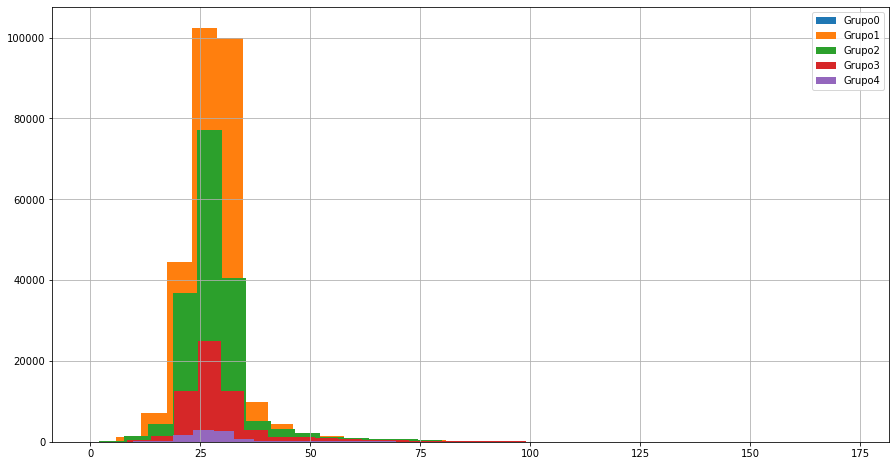

In [41]:
plt.figure(figsize=(15,8))

#dias1=datos[datos.Ciudad=='Santa Marta']
dias1=datos

for i in range(5):
    dias=dias1[dias1.Grupo_etario==i].Fecha_recuperado-dias1[dias1.Grupo_etario==i].Fecha_minima
    dias=dias.astype(str).str.replace(" 00:00:00.000000000","").str.replace(" days","")
    dias=dias.apply(lambda fecha: Fechas_Neg(fecha))
    dias=dias[dias!='NaT'].astype(float)
    dias=dias[dias>=0]
    print("Mediana:",dias.median())
    print("Media  :",dias.mean())
    print("Mínimo :",dias.min(),'\n')
    #dias
    
    plt.hist(dias,bins=30,label='Grupo'+str(i))
    plt.legend()
    plt.grid()
    
plt.show()

## Días con la enfermedad hasta Deceso

Mediana: 10.0
Media  : 14.695652173913043
Mínimo : 0.0 

Mediana: 13.0
Media  : 16.43050193050193
Mínimo : 0.0 

Mediana: 14.0
Media  : 16.297928513403736
Mínimo : 0.0 

Mediana: 14.0
Media  : 16.10845651426607
Mínimo : 0.0 

Mediana: 11.0
Media  : 13.309168781725889
Mínimo : 0.0 



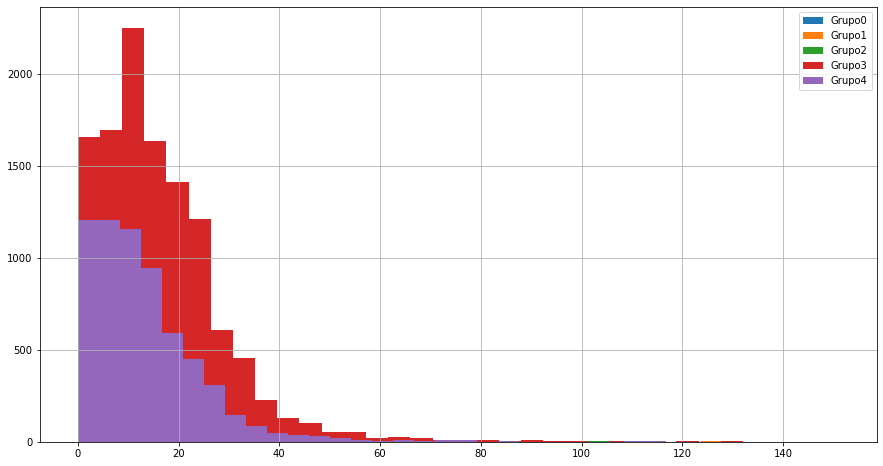

In [42]:
plt.figure(figsize=(15,8))

for i in range(5):
    dias=datos[datos.Grupo_etario==i].Fecha_muerte-datos[datos.Grupo_etario==i].Fecha_minima
    dias=dias.astype(str).str.replace(" 00:00:00.000000000","").str.replace(" days","")
    dias=dias.apply(lambda fecha: Fechas_Neg(fecha))
    dias=dias[dias!='NaT'].astype(float)
    dias=dias[dias>=0]
    datos['Dias_hasta_muerte']=dias
    print("Mediana:",dias.median())
    print("Media  :",dias.mean())
    print("Mínimo :",dias.min(),'\n')
    
    plt.hist(dias,bins=30,label='Grupo'+str(i))
    plt.legend()
    plt.grid()
    
plt.show()

# Generar Consultas

# Conteos

## Inicio Síntomas 

In [43]:
sintomas=pd.DataFrame(datos.groupby('Fecha_inicio_sintoma')[['Fecha_inicio_sintoma']].count())
print("\nSintomas Totales:",sintomas.values.sum()) # No concuerda con los oficiales
sintomas


Sintomas Totales: 615633


,Fecha_inicio_sintoma
Fecha_inicio_sintoma,
2020-02-27,1
2020-02-28,1
2020-02-29,2
2020-03-01,5
2020-03-02,4
...,...
2020-09-06,747
2020-09-07,969
2020-09-08,518


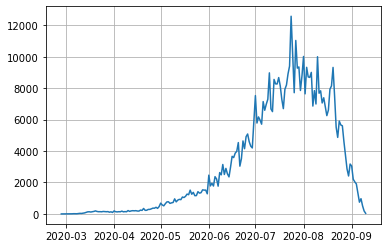

In [44]:
plt.plot(sintomas)
plt.grid()
plt.show()

## Notificados 

In [45]:
notif=pd.DataFrame(datos.groupby('Fecha_notificacion')[['Fecha_notificacion']].count())
print("\nNotificaciones Totales:",notif.values.sum(),'\n')
notif


Notificaciones Totales: 702088 



,Fecha_notificacion
Fecha_notificacion,
2020-03-02,1
2020-03-06,1
2020-03-07,1
2020-03-08,2
2020-03-09,3
...,...
2020-09-07,4030
2020-09-08,2524
2020-09-09,1451


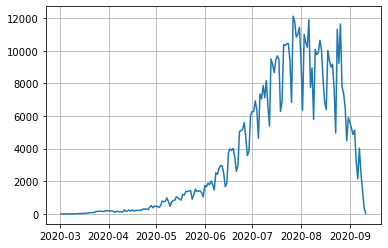

In [49]:
plt.plot(notif)
plt.grid()
plt.show()

## Diagnosticados 

In [50]:
diag=pd.DataFrame(datos.groupby('Fecha_diagnostico')[['Fecha_diagnostico']].count())
print("\nDiagnosticados Totales:",diag.values.sum(),'\n')
diag.values #Sus y


Diagnosticados Totales: 698063 



array([[    1],
       [    2],
       [    6],
       [    5],
       [    5],
       [   18],
       [   16],
       [   14],
       [   25],
       [   12],
       [   26],
       [   48],
       [   34],
       [   29],
       [   74],
       [  105],
       [   61],
       [   10],
       [   49],
       [   69],
       [   95],
       [   96],
       [  107],
       [  161],
       [   97],
       [  106],
       [  139],
       [   79],
       [   98],
       [  132],
       [  347],
       [  173],
       [  250],
       [  235],
       [   68],
       [   75],
       [  123],
       [  126],
       [  128],
       [  204],
       [  184],
       [  175],
       [  182],
       [  174],
       [  194],
       [  196],
       [  305],
       [  262],
       [  238],
       [  217],
       [  353],
       [  260],
       [  309],
       [  482],
       [  281],
       [  421],
       [  307],
       [  641],
       [  350],
       [  500],
       [  595],
       [  445],
       [

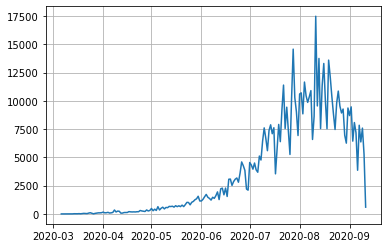

In [53]:
plt.plot(diag)
plt.grid()
plt.show()

## Recuperados

### Recuperados Diagnosticados 

Este conteo puede tener dos interpretaciones: Los recuperados **sin diagnóstico** y los **recuperados con diagnóstico.**

In [54]:
# Tomar los recuperados CON DIAGNOSTICO
recu_diag=pd.DataFrame(datos.groupby('Fecha_recuperado')['Fecha_diagnostico'].count())
print("\nRecuperados Diagnosticados:",recu_diag.values.sum(),'\n')
recu_diag=recu_diag.rename(columns={'Fecha_diagnostico':'Fecha_recuperado_diag'})
recu_diag


Recuperados Diagnosticados: 578974 



,Fecha_recuperado_diag
Fecha_recuperado,
2020-03-13,1
2020-03-14,1
2020-03-15,1
2020-03-17,1
2020-03-19,1
...,...
2020-09-07,11204
2020-09-08,11789
2020-09-09,11553


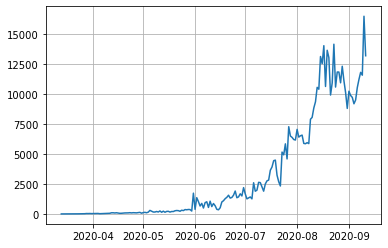

In [55]:
plt.plot(recu_diag)
plt.grid()
plt.show()

### Recuperados Totales (Diagnosticados y No Diagnosticados)

In [56]:
# Tomar los recuperados CON Y SIN DIAGNOSTICO
recu_todo=pd.DataFrame(datos.groupby('Fecha_recuperado')['Fecha_recuperado'].count())
print("\nRecuperados Totales:",recu_todo.values.sum(),'\n')
recu_todo


Recuperados Totales: 582699 



,Fecha_recuperado
Fecha_recuperado,
2020-03-13,1
2020-03-14,1
2020-03-15,1
2020-03-17,1
2020-03-19,1
...,...
2020-09-07,11257
2020-09-08,11815
2020-09-09,11557


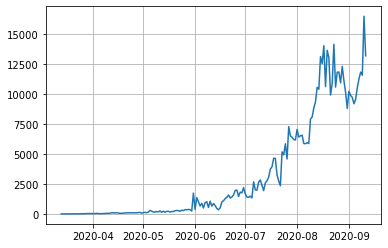

In [57]:
plt.plot(recu_todo)
plt.grid()
plt.show()

## Fallecidos 

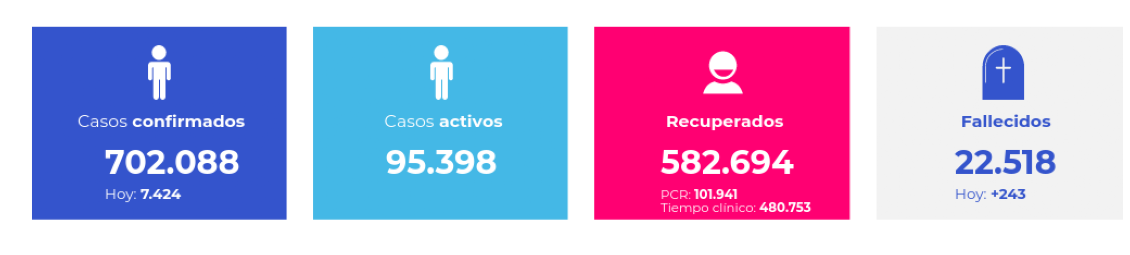

In [5]:
img = mpimg.imread('../Imagenes/pandas_'+fecha+'.png')

plt.figure(figsize=(20,8))
plt.imshow(img)
plt.axis('off')
plt.show()

### Fallecidos Diagnosticados

In [58]:
muerte_diag=pd.DataFrame(datos.groupby('Fecha_muerte')[['Fecha_diagnostico']].count())
muertos_hoy_ins=5307

print("\nFallecidos Totales:",muerte_diag.values.sum()) # No concuerda con los oficiales
print("Fallecidos Reporte:",muertos_hoy_ins)
print("Desfase           :  ",muerte_diag.values.sum()-muertos_hoy_ins,'\n')

muerte_diag=muerte_diag.rename(columns={'Fecha_diagnostico':'Fecha_muerte_diag'})
muerte_diag


Fallecidos Totales: 23798
Fallecidos Reporte: 5307
Desfase           :   18491 



,Fecha_muerte_diag
Fecha_muerte,
2020-03-16,1
2020-03-22,1
2020-03-23,1
2020-03-24,1
2020-03-25,4
...,...
2020-09-07,203
2020-09-08,181
2020-09-09,166


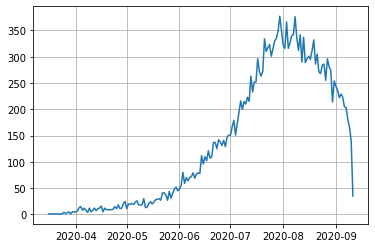

In [59]:
plt.plot(muerte_diag)
plt.grid()
plt.show()

### Fallecidos Totales (Diagnosticados y No Diagnosticados)

In [60]:
muerte_todo=pd.DataFrame(datos.groupby('Fecha_muerte')[['Fecha_muerte']].count())

print("\nFallecidos Totales:",muerte_todo.values.sum()) # No concuerda con los oficiales
print("Fallecidos Reporte:",muertos_hoy_ins)
print("Desfase           : ",muerte_todo.values.sum()-muertos_hoy_ins,'\n')
muerte_todo


Fallecidos Totales: 24019
Fallecidos Reporte: 5307
Desfase           :  18712 



,Fecha_muerte
Fecha_muerte,
2020-03-16,1
2020-03-22,1
2020-03-23,1
2020-03-24,1
2020-03-25,4
...,...
2020-09-07,203
2020-09-08,181
2020-09-09,166


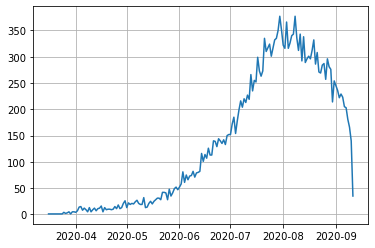

In [61]:
plt.plot(muerte_todo)
plt.grid()
plt.show()

### Fallecidos Convalecentes (Diagnosticados)

### Recuperados antes de 10 días

In [62]:
prontos=datos[np.logical_and(datos.Fecha_recuperado<=datos.Fecha_fase_uno,-pd.isnull(datos.Fecha_diagnostico))]
prontos=prontos.groupby('Fecha_recuperado')['Fecha_diagnostico'].count()
prontos

Fecha_recuperado
2020-03-25     4
2020-03-28     1
2020-03-30     2
2020-03-31     1
2020-04-04     5
              ..
2020-09-05    13
2020-09-06    11
2020-09-07    18
2020-09-08    13
2020-09-09    14
Name: Fecha_diagnostico, Length: 156, dtype: int64

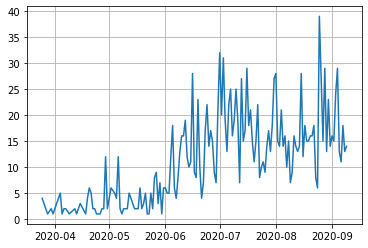

In [63]:
plt.plot(prontos)
plt.grid()
plt.show()

### Fallecidos antes de 10 días

In [64]:
graves=datos[np.logical_and(datos.Fecha_muerte<=datos.Fecha_fase_uno,-pd.isnull(datos.Fecha_diagnostico))]
graves=graves.groupby('Fecha_muerte')['Fecha_diagnostico'].count()
graves

Fecha_muerte
2020-03-16     1
2020-03-24     1
2020-03-25     2
2020-03-26     1
2020-03-27     1
              ..
2020-09-07    31
2020-09-08    31
2020-09-09    15
2020-09-10    20
2020-09-11     3
Name: Fecha_diagnostico, Length: 171, dtype: int64

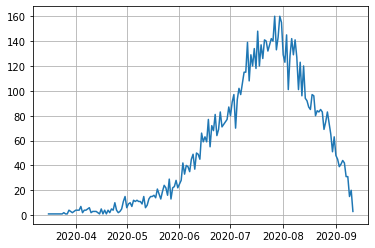

In [65]:
plt.plot(graves)
plt.grid()
plt.show()

In [66]:
graves2=datos[np.logical_and(datos.Fecha_muerte>datos.Fecha_fase_uno,-pd.isnull(datos.Fecha_diagnostico))]
graves2=graves2.groupby('Fecha_muerte')['Fecha_diagnostico'].count()
graves2

Fecha_muerte
2020-03-22      1
2020-03-23      1
2020-03-25      2
2020-03-26      1
2020-03-27      2
             ... 
2020-09-07    172
2020-09-08    150
2020-09-09    151
2020-09-10    119
2020-09-11     32
Name: Fecha_diagnostico, Length: 172, dtype: int64

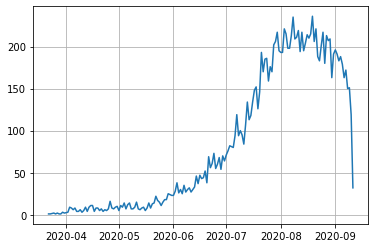

In [67]:
plt.plot(graves2)
plt.grid()
plt.show()

## Cuentas Activos

In [68]:
activos_hoy_ins=81360
activos=notif.values.sum()-recu_todo.values.sum()-muerte_todo.values.sum() # NO CUADRAN LAS CIFRAS
print("Activos Totales:",activos)
print("Activos Reporte:",activos_hoy_ins)
print("Desfase        :  ",activos-activos_hoy_ins)

Activos Totales: 95370
Activos Reporte: 81360
Desfase        :   14010


In [69]:
activos_hoy_ins=81360
activos=diag.values.sum()-recu_diag.values.sum()-muerte_diag.values.sum() # NO CUADRAN LAS CIFRAS
print("Activos Totales:",activos)
print("Activos Reporte:",activos_hoy_ins)
print("Desfase        : ",activos-activos_hoy_ins)

Activos Totales: 95291
Activos Reporte: 81360
Desfase        :  13931


# Consolidar Base de Datos Diarios 

In [70]:
#datos_limpios=pd.DataFrame(notif,infec,recu,muerte)
datos_coincide=pd.merge(notif,diag,left_index=True,right_index=True) # Junta quitando todo lo que no coincide

## Merge unifica todas las coincidencias y cuando no hay llena con NaN

datos_todo=pd.merge(sintomas,notif,left_index=True,right_index=True,how='outer') # Comienza con inicio sintomas y unifica con notificados
datos_todo=pd.merge(datos_todo,diag,left_index=True,right_index=True,how='outer') # Unifica con Diagnosticados
#datos_todo=pd.merge(datos_todo,recu_todo,left_index=True,right_index=True,how='outer') # Unifica con Recuperados
datos_todo=pd.merge(datos_todo,recu_diag,left_index=True,right_index=True,how='outer') # Unifica con Recuperados Diagnosticados
datos_todo=pd.merge(datos_todo,muerte_diag,left_index=True,right_index=True,how='outer') # Unifica con Fallecidos
datos_todo

,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado_diag,Fecha_muerte_diag
2020-02-27,1.0,NaN,NaN,NaN,NaN
2020-02-28,1.0,NaN,NaN,NaN,NaN
2020-02-29,2.0,NaN,NaN,NaN,NaN
2020-03-01,5.0,NaN,NaN,NaN,NaN
2020-03-02,4.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...
2020-09-07,969.0,4030.0,7843.0,11204.0,203.0
2020-09-08,518.0,2524.0,6366.0,11789.0,181.0
2020-09-09,189.0,1451.0,7589.0,11553.0,166.0
2020-09-10,38.0,393.0,5270.0,16461.0,139.0


## Verificar si los indíces llenaron todas las fechas 

In [71]:
from datetime import timedelta
fecha_inicio=pd.to_datetime(datos.Fecha_inicio_sintoma[0],format='%Y-%m-%d')
print("\nInicio  :",fecha_inicio)
print("Final   :",fecha_inicio+timedelta(days=int(len(datos_todo)-1)))


Inicio  : 2020-02-27 00:00:00
Final   : 2020-09-11 00:00:00


# Colocar Dia como Número Discreto

In [72]:
dia=range(-8,len(datos_todo)-8)
datos_todo.insert(0,'Dia_numero',dia,True)

# Visualizar Consolidado 

In [73]:
datos_todo

,Dia_numero,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado_diag,Fecha_muerte_diag
2020-02-27,-8,1.0,NaN,NaN,NaN,NaN
2020-02-28,-7,1.0,NaN,NaN,NaN,NaN
2020-02-29,-6,2.0,NaN,NaN,NaN,NaN
2020-03-01,-5,5.0,NaN,NaN,NaN,NaN
2020-03-02,-4,4.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-09-07,185,969.0,4030.0,7843.0,11204.0,203.0
2020-09-08,186,518.0,2524.0,6366.0,11789.0,181.0
2020-09-09,187,189.0,1451.0,7589.0,11553.0,166.0
2020-09-10,188,38.0,393.0,5270.0,16461.0,139.0


## Llenar NaN con Ceros 

In [74]:
datos_todo=datos_todo.fillna(0)
datos_todo

,Dia_numero,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado_diag,Fecha_muerte_diag
2020-02-27,-8,1.0,0.0,0.0,0.0,0.0
2020-02-28,-7,1.0,0.0,0.0,0.0,0.0
2020-02-29,-6,2.0,0.0,0.0,0.0,0.0
2020-03-01,-5,5.0,0.0,0.0,0.0,0.0
2020-03-02,-4,4.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2020-09-07,185,969.0,4030.0,7843.0,11204.0,203.0
2020-09-08,186,518.0,2524.0,6366.0,11789.0,181.0
2020-09-09,187,189.0,1451.0,7589.0,11553.0,166.0
2020-09-10,188,38.0,393.0,5270.0,16461.0,139.0


## Generar Infectados Activos Diarios

In [75]:
diag_act=pd.DataFrame(datos_todo.Fecha_diagnostico.cumsum()-datos_todo.Fecha_recuperado_diag.cumsum()-datos_todo.Fecha_muerte_diag.cumsum(),\
                     columns=['Diag_activos'])
diag_act

,Diag_activos
2020-02-27,0.0
2020-02-28,0.0
2020-02-29,0.0
2020-03-01,0.0
2020-03-02,0.0
...,...
2020-09-07,128964.0
2020-09-08,123360.0
2020-09-09,119230.0
2020-09-10,107900.0


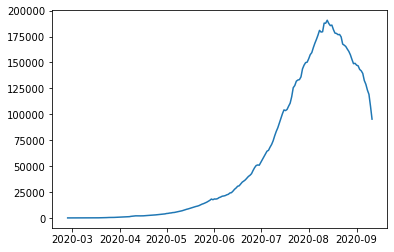

In [76]:
plt.plot(diag_act)

## Generar Infectados Activos Diarios

In [77]:
notif_act=pd.DataFrame(datos_todo.Fecha_notificacion.cumsum()-datos_todo.Fecha_recuperado_diag.cumsum()-datos_todo.Fecha_muerte_diag.cumsum(),\
                     columns=['Diag_activos'])
notif_act

,Diag_activos
2020-02-27,0.0
2020-02-28,0.0
2020-02-29,0.0
2020-03-01,0.0
2020-03-02,1.0
...,...
2020-09-07,148423.0
2020-09-08,138977.0
2020-09-09,128709.0
2020-09-10,112502.0


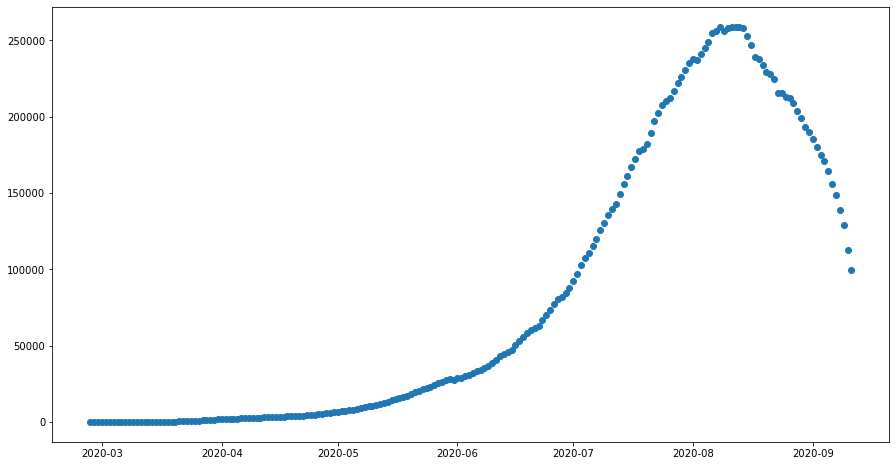

In [78]:
plt.figure(figsize=(15,8))
plt.plot(notif_act,'o')

## Generar Recuperados Acumulados Diagnosticados Diarios 

In [79]:
rec_act=pd.DataFrame(datos_todo.Fecha_recuperado_diag.cumsum())
rec_act=rec_act.rename(columns={'Fecha_recuperado_diag':'Recuperado_diag_activos'})
rec_act

,Recuperado_diag_activos
2020-02-27,0.0
2020-02-28,0.0
2020-02-29,0.0
2020-03-01,0.0
2020-03-02,0.0
...,...
2020-09-07,525999.0
2020-09-08,537788.0
2020-09-09,549341.0
2020-09-10,565802.0


## Generar Muertos Acumulados Diagnosticados Diarios

In [80]:
muerte_act=pd.DataFrame(datos_todo.Fecha_muerte_diag.cumsum())
muerte_act=muerte_act.rename(columns={'Fecha_muerte_diag':'Muerte_diag_activos'})
muerte_act

,Muerte_diag_activos
2020-02-27,0.0
2020-02-28,0.0
2020-02-29,0.0
2020-03-01,0.0
2020-03-02,0.0
...,...
2020-09-07,23277.0
2020-09-08,23458.0
2020-09-09,23624.0
2020-09-10,23763.0


# Consolidar Consulta 

In [81]:
datos_todo=pd.merge(datos_todo,diag_act,left_index=True,right_index=True,how='outer') # Unifica Infectados Activos Diarios
datos_todo=pd.merge(datos_todo,rec_act,left_index=True,right_index=True,how='outer') # Unifica Recuperados Acumulados
datos_todo=pd.merge(datos_todo,muerte_act,left_index=True,right_index=True,how='outer') # Unifica Fallecidos Acumulados
datos_todo

,Dia_numero,Fecha_inicio_sintoma,Fecha_notificacion,Fecha_diagnostico,Fecha_recuperado_diag,Fecha_muerte_diag,Diag_activos,Recuperado_diag_activos,Muerte_diag_activos
2020-02-27,-8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-28,-7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-29,-6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-01,-5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-02,-4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2020-09-07,185,969.0,4030.0,7843.0,11204.0,203.0,128964.0,525999.0,23277.0
2020-09-08,186,518.0,2524.0,6366.0,11789.0,181.0,123360.0,537788.0,23458.0
2020-09-09,187,189.0,1451.0,7589.0,11553.0,166.0,119230.0,549341.0,23624.0
2020-09-10,188,38.0,393.0,5270.0,16461.0,139.0,107900.0,565802.0,23763.0


# Guardar Datos 

## Formato .csv 

In [82]:
datos_todo.to_csv('../Datos/Final_'+fecha+'.csv')

## Formato Pickle

In [83]:
datos_todo.to_pickle('../Datos/Final_'+fecha+'.p')

# Visualizacion Datos 

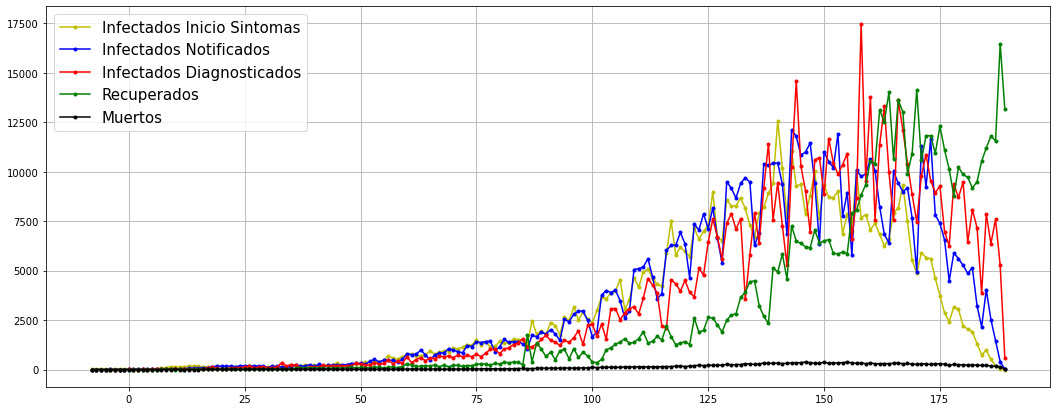

In [84]:
plt.figure(figsize=(18,7))

# Infectados
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_inicio_sintoma,'y.-',label='Infectados Inicio Sintomas')
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_notificacion,'b.-',label='Infectados Notificados')
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_diagnostico,'r.-',label='Infectados Diagnosticados')

# Recuperados
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_recuperado_diag,'g.-',label='Recuperados')

#Fallecidos
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_muerte_diag,'k.-',label='Muertos')

plt.legend(fontsize=15)
plt.grid()
plt.show()

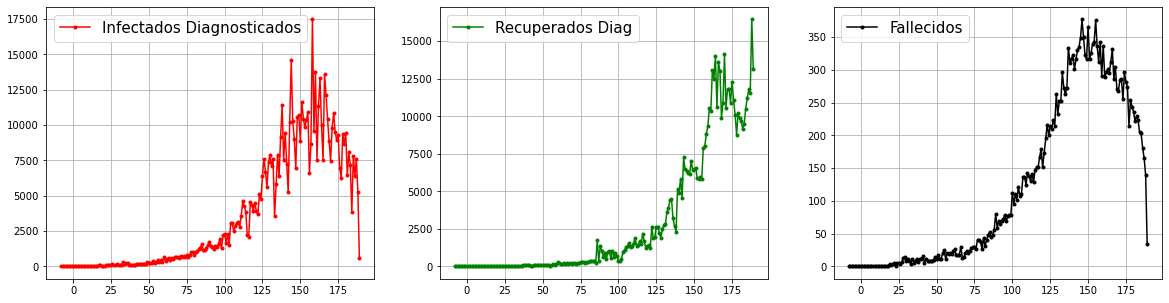

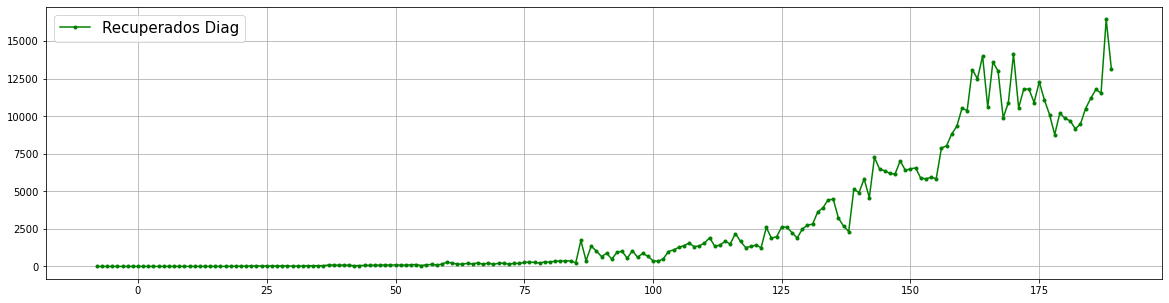

In [85]:
plt.figure(figsize=(20,5))

# Infectados
plt.subplot(131)
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_diagnostico,'r.-',label='Infectados Diagnosticados')
plt.legend(fontsize=15)
plt.grid()

# Recuperados
plt.subplot(132)
#plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_recuperado,'b.-',label='Recuperados')
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_recuperado_diag,'g.-',label='Recuperados Diag')
plt.legend(fontsize=15)
plt.grid()

#Fallecidos
plt.subplot(133)
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_muerte_diag,'k.-',label='Fallecidos')
plt.legend(fontsize=15)
plt.grid()

plt.show()

# Recuperados
plt.figure(figsize=(20,5))
#plt.plot(recu_diag,'b.-',label='Recuperados')
plt.plot(datos_todo.Dia_numero,datos_todo.Fecha_recuperado_diag,'g.-',label='Recuperados Diag')
plt.legend(fontsize=15)
plt.grid()

# Capturar Efectividad Cuarentena

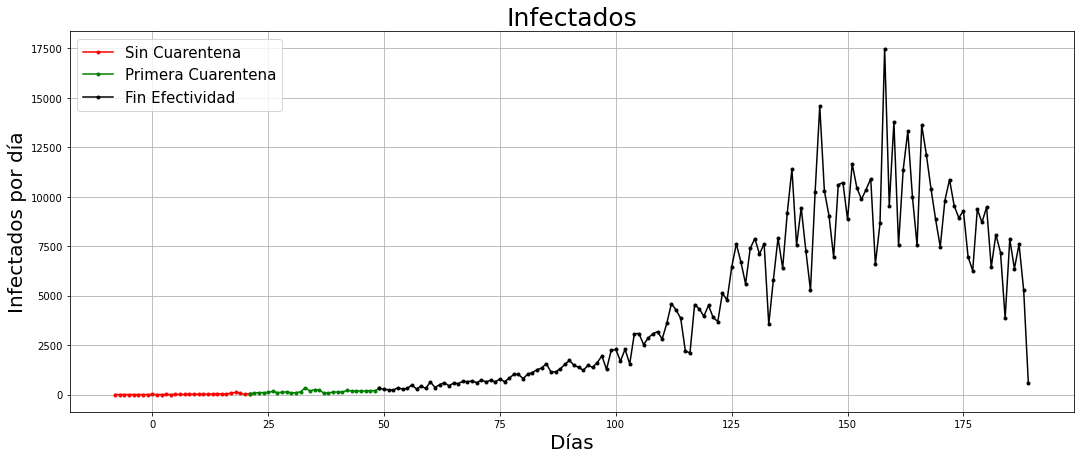

In [86]:
plt.figure(figsize=(18,7))
# Sin Cuarentena
### Fechas
#plt.plot(np.sort(datos_diag['Fecha_diagnostico'].unique())[:15],infec[:15],'o--')
plt.plot(datos_todo.Dia_numero[:30],datos_todo.Fecha_diagnostico[:30],'r.-',label='Infectados Diagnosticados')
# Con cuarentena
#plt.plot(np.sort(datos_diag['Fecha_diagnostico'].unique())[14:58],infec[14:58],'o--')
plt.plot(datos_todo.Dia_numero[29:58],datos_todo.Fecha_diagnostico[29:58],'g.-',label='Infectados Diagnosticados')
# Fin Efectividad
#plt.plot(np.sort(datos_diag['Fecha_diagnostico'].unique())[57:],infec[57:],'ro--')
plt.plot(datos_todo.Dia_numero[57:],datos_todo.Fecha_diagnostico[57:],'k.-',label='Infectados Diagnosticados')
plt.legend(['Sin Cuarentena','Primera Cuarentena','Fin Efectividad'],fontsize=15)
plt.title('Infectados',fontsize=25)
plt.xlabel('Días',fontsize=20)
plt.ylabel('Infectados por día',fontsize=20)
plt.grid()
plt.show()

# DataFrame Final (Datos Bonitos) 

## Infectados Diagnosticados

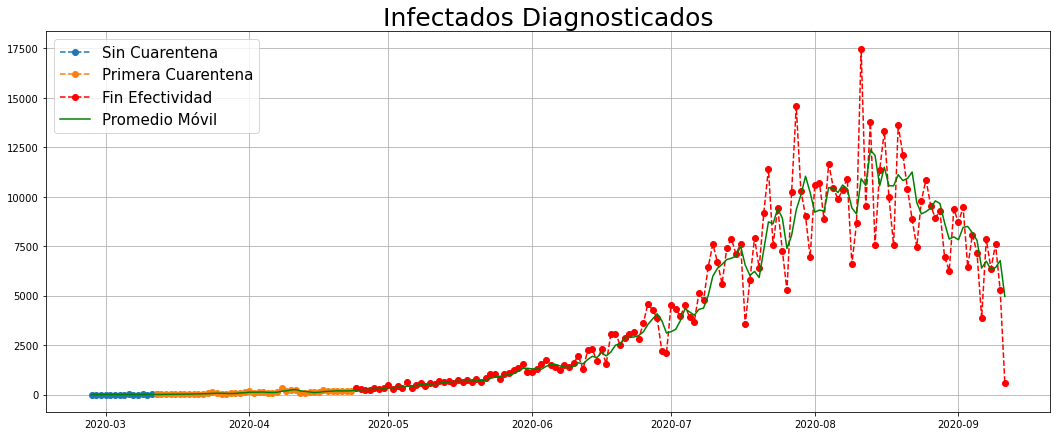

,Fecha_diagnostico,Dia,Prom_mov
2020-02-27,0.0,-8,0.00
2020-02-28,0.0,-7,0.00
2020-02-29,0.0,-6,0.00
2020-03-01,0.0,-5,0.00
2020-03-02,0.0,-4,0.00
...,...,...,...
2020-09-07,7843.0,185,6740.00
2020-09-08,6366.0,186,6311.50
2020-09-09,7589.0,187,6414.75
2020-09-10,5270.0,188,6767.00


In [87]:
#Creando DataFrame
limpia=pd.DataFrame(datos_todo[-datos_todo.Fecha_diagnostico.isna()].Fecha_diagnostico)

# Tamaño de Ventana
ventana=4
# Moving Average
mav=limpia.Fecha_diagnostico.rolling(window=ventana).mean()
mav[:ventana]=limpia.Fecha_diagnostico[:ventana].values
limpia['Dia']=datos_todo.Dia_numero[limpia.index]
limpia['Prom_mov']=mav

plt.figure(figsize=(18,7))
# Sin Cuarentena
plt.plot(limpia.index[:15],limpia.Fecha_diagnostico[:15],'o--')
# Con cuarentena
plt.plot(limpia.index[14:58],limpia.Fecha_diagnostico[14:58],'o--')
# Fin Efectividad
plt.plot(limpia.index[57:],limpia.Fecha_diagnostico[57:],'ro--')
# Promedio Movil
plt.plot(limpia.index,limpia.Prom_mov,'g-')
plt.legend(['Sin Cuarentena','Primera Cuarentena','Fin Efectividad','Promedio Móvil'],fontsize=15)
plt.title("Infectados Diagnosticados",fontsize=25)
plt.grid()
plt.show()

limpia

### Regresión Datos Puros

In [88]:
def I_diag_m(t,a,b,c,d):
    return a*np.exp(b*t+c)+d

params_pure,_= curve_fit(I_diag_m, limpia.Dia, limpia.Fecha_diagnostico,maxfev=10000)
print(params_pure)

[-7.40882029e-26  9.98624226e-01  1.04892312e-04 -8.00371376e+50]


### Regresión Promedio Móvil

In [89]:
def model_diag_mav(t,a,b,c,d):
    return a*np.exp(b*t+c)+d

params_pmov,_= curve_fit(model_diag_mav, limpia.Dia, limpia.Prom_mov,maxfev = 10000)
print(params_pmov)

[3.09144905e-79 9.98623677e-01 6.68020106e-06 3.47741506e+03]


### Gráficas

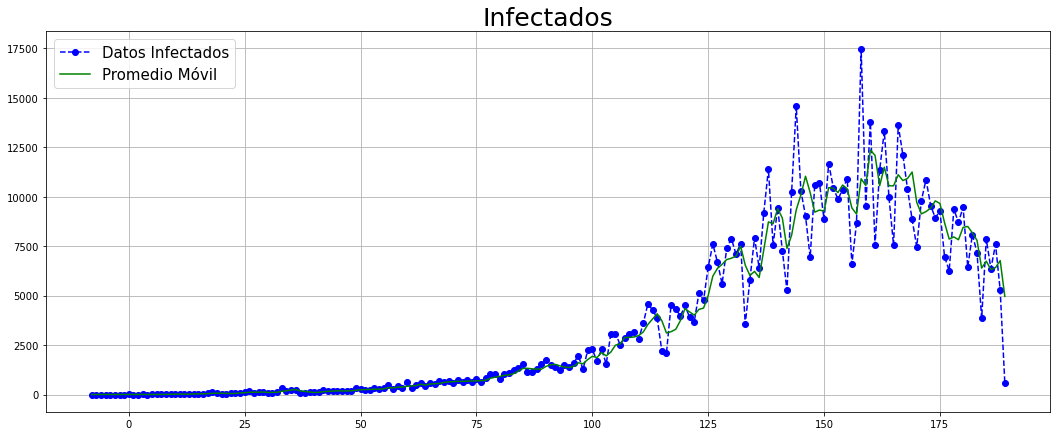

In [90]:
plt.figure(figsize=(18,7))
#Datos
plt.plot(limpia.Dia,limpia.Fecha_diagnostico,'bo--')
# Promedio Movil
plt.plot(limpia.Dia,limpia.Prom_mov,'g-')
# Regresión Exponencial
#plt.plot(limpia.Dia,I_diag_m(limpia.Dia,*params_pure),'r-')
#plt.plot(limpia.Dia,model_diag_mav(limpia.Dia,*params_pmov),'k-')
plt.legend(['Datos Infectados','Promedio Móvil','Regresión Datos','Regresión Prom. Móvil'],fontsize=15)
plt.title("Infectados",fontsize=25)
plt.grid()
plt.show()

## Recuperados

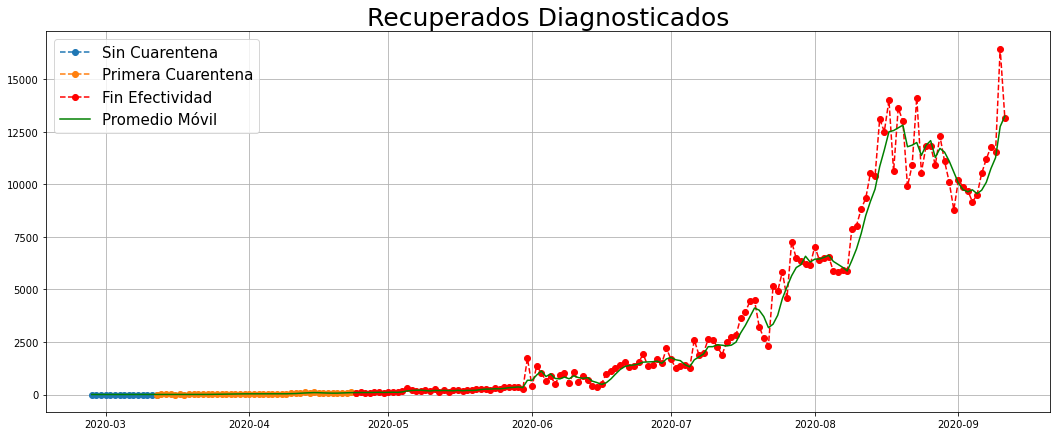

,Fecha_recuperado_diag,Dia,Prom_mov
2020-02-27,0.0,-8,0.00
2020-02-28,0.0,-7,0.00
2020-02-29,0.0,-6,0.00
2020-03-01,0.0,-5,0.00
2020-03-02,0.0,-4,0.00
...,...,...,...
2020-09-07,11204.0,185,10095.50
2020-09-08,11789.0,186,10749.75
2020-09-09,11553.0,187,11266.25
2020-09-10,16461.0,188,12751.75


In [91]:
#Creando DataFrame
limpia=pd.DataFrame(datos_todo[-datos_todo.Fecha_recuperado_diag.isna()].Fecha_recuperado_diag)

# Tamaño de Ventana
ventana=4
# Moving Average
mav=limpia.Fecha_recuperado_diag.rolling(window=ventana).mean()
mav[:ventana]=limpia.Fecha_recuperado_diag[:ventana].values
limpia['Dia']=datos_todo.Dia_numero[limpia.index]
limpia['Prom_mov']=mav

plt.figure(figsize=(18,7))
# Sin Cuarentena
plt.plot(limpia.index[:15],limpia.Fecha_recuperado_diag[:15],'o--')
# Con cuarentena
plt.plot(limpia.index[14:58],limpia.Fecha_recuperado_diag[14:58],'o--')
# Fin Efectividad
plt.plot(limpia.index[57:],limpia.Fecha_recuperado_diag[57:],'ro--')
# Promedio Movil
plt.plot(limpia.index,limpia.Prom_mov,'g-')
plt.legend(['Sin Cuarentena','Primera Cuarentena','Fin Efectividad','Promedio Móvil'],fontsize=15)
plt.title("Recuperados Diagnosticados",fontsize=25)
plt.grid()
plt.show()

limpia

### Regresión Datos Puros

In [92]:
def R_diag_m(t,a,b,c,d):
    return a*np.exp(b*t+c)+d

params_pure,_= curve_fit(R_diag_m, limpia.Dia, limpia.Fecha_recuperado_diag,maxfev=10000)
print(params_pure)

[ 4.60372897e+00  2.05978019e-02  4.22882500e+00 -8.51011380e+02]


### Regresión Promedio Móvil

In [93]:
def model_diag_mav(t,a,b,c,d):
    return a*np.exp(b*t+c)+d

params_pmov,_= curve_fit(model_diag_mav, limpia.Dia, limpia.Prom_mov,maxfev = 10000)
print(params_pmov)

[ 1.48727774e-78  9.98623757e-01 -6.76610717e-06  2.70740825e+03]


### Gráficas

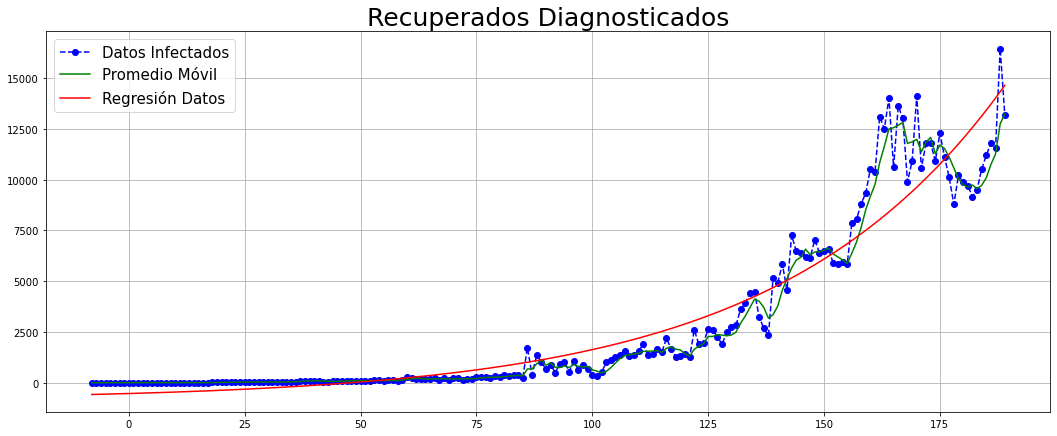

In [96]:
plt.figure(figsize=(18,7))
#Datos
plt.plot(limpia.Dia,limpia.Fecha_recuperado_diag,'bo--')
# Promedio Movil
plt.plot(limpia.Dia,limpia.Prom_mov,'g-')
# Regresión Exponencial
plt.plot(limpia.Dia,R_diag_m(limpia.Dia,*params_pure),'r-')
#plt.plot(limpia.Dia,model_diag_mav(limpia.Dia,*params_pmov),'k-')
plt.legend(['Datos Infectados','Promedio Móvil','Regresión Datos','Regresión Prom. Móvil'],fontsize=15)
plt.title("Recuperados Diagnosticados",fontsize=25)
plt.grid()
plt.show()

# Grupos Etarios 

## Filtro Etario 


Total Muertos Entre 0  y 20:   133
Total Muertos Entre 20 y 40:  1123
Total Muertos Entre 40 y 60: 5262
Total Muertos Entre 60 y 80: 11798
Total Muertos Mayores de 80: 5612
Total Muertos En el Filtro : 23928

Total Muertos Base de Datos: 23928


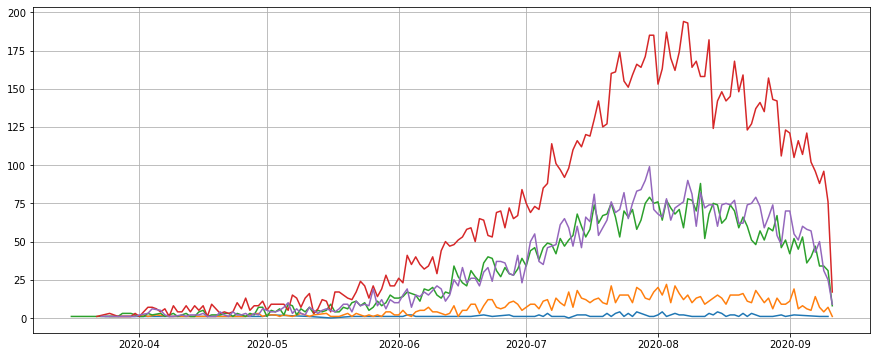

In [99]:
### Hiperparámetros Filtros

edad0=0
edad1=20
edad2=40
edad3=60
edad4=80
edadm=max(datos.Edad.values)

### Tipo Filtro

agrupa='Fecha_muerte'
filtro='Fecha_inicio_sintoma'

## Muertes Diagnosticadas

muerte_diag=pd.DataFrame(datos.groupby(agrupa)[filtro].count())

filtro_edad0=datos[np.logical_and(datos.Edad>=edad0,datos.Edad<=edad1)].groupby(agrupa)[filtro].count()
filtro_edad1=datos[np.logical_and(datos.Edad >edad1,datos.Edad<=edad2)].groupby(agrupa)[filtro].count()
filtro_edad2=datos[np.logical_and(datos.Edad >edad2,datos.Edad<=edad3)].groupby(agrupa)[filtro].count()
filtro_edad3=datos[np.logical_and(datos.Edad >edad3,datos.Edad<=edad4)].groupby(agrupa)[filtro].count()
filtro_edad4=datos[np.logical_and(datos.Edad >edad4,datos.Edad<=edadm)].groupby(agrupa)[filtro].count()


print("\nTotal Muertos Entre "+str(edad0)+"  y "+str(edad1)+':  ',filtro_edad0.sum())
print("Total Muertos Entre "  +str(edad1)+" y "+str(edad2)+': ',filtro_edad1.sum())
print("Total Muertos Entre "  +str(edad2)+" y "+str(edad3)+':',filtro_edad2.sum())
print("Total Muertos Entre "  +str(edad3)+" y "+str(edad4)+':',filtro_edad3.sum())
print("Total Muertos Mayores de "+str(edad4)+':',filtro_edad4.sum())

print("Total Muertos En el Filtro :",filtro_edad0.sum()+filtro_edad1.sum()+filtro_edad2.sum()+filtro_edad3.sum()+filtro_edad4.sum())
print("\nTotal Muertos Base de Datos:",muerte_diag.values.sum())

plt.figure(figsize=(15,6))

plt.plot(filtro_edad0)
plt.plot(filtro_edad1)
plt.plot(filtro_edad2)
plt.plot(filtro_edad3)
plt.plot(filtro_edad4)
plt.grid()
plt.show()


Total Diagnosticados Entre 0  y 20: 67714
Total Diagnosticados Entre 20 y 40: 280201
Total Diagnosticados Entre 40 y 60: 176466
Total Diagnosticados Entre 60 y 80: 72103
Total Diagnosticados Mayores de 80: 5612
Total Diagnosticados En el Filtro : 611655

Total Diagnosticados Base de Datos: 611655


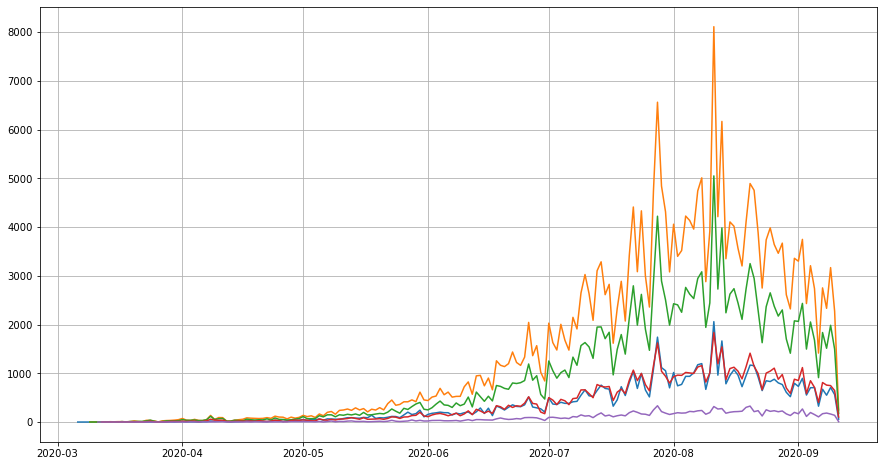

In [100]:
### Tipo Filtro

agrupa='Fecha_diagnostico'
filtro='Fecha_inicio_sintoma'

## Muertes Diagnosticadas

diag=pd.DataFrame(datos.groupby(agrupa)[filtro].count())

filtro_edad0d=datos[np.logical_and(datos.Edad>=edad0,datos.Edad<=edad1)].groupby(agrupa)[filtro].count()
filtro_edad1d=datos[np.logical_and(datos.Edad>edad1,datos.Edad<=edad2)].groupby(agrupa)[filtro].count()
filtro_edad2d=datos[np.logical_and(datos.Edad>edad2,datos.Edad<=edad3)].groupby(agrupa)[filtro].count()
filtro_edad3d=datos[np.logical_and(datos.Edad>edad3,datos.Edad<=edad4)].groupby(agrupa)[filtro].count()
filtro_edad4d=datos[np.logical_and(datos.Edad>edad4,datos.Edad<=edadm)].groupby(agrupa)[filtro].count()


print("\nTotal Diagnosticados Entre "+str(edad0)+"  y "+str(edad1)+':',filtro_edad0d.sum())
print("Total Diagnosticados Entre "  +str(edad1)+" y "+str(edad2)+':',filtro_edad1d.sum())
print("Total Diagnosticados Entre "  +str(edad2)+" y "+str(edad3)+':',filtro_edad2d.sum())
print("Total Diagnosticados Entre "  +str(edad3)+" y "+str(edad4)+':',filtro_edad3d.sum())
print("Total Diagnosticados Mayores de "+str(edad4)+':',filtro_edad4.sum())

print("Total Diagnosticados En el Filtro :",filtro_edad0d.sum()+filtro_edad1d.sum()+filtro_edad2d.sum()+filtro_edad3d.sum()+filtro_edad4d.sum())
print("\nTotal Diagnosticados Base de Datos:",diag.values.sum())

plt.figure(figsize=(15,8))

plt.plot(filtro_edad0d)
plt.plot(filtro_edad1d)
plt.plot(filtro_edad2d)
plt.plot(filtro_edad3d)
plt.plot(filtro_edad4d)
plt.grid()
plt.show()

# Tasas

In [101]:
tasa0=filtro_edad0.sum()/filtro_edad0d.sum()
tasa1=filtro_edad1.sum()/filtro_edad1d.sum()
tasa2=filtro_edad2.sum()/filtro_edad2d.sum()
tasa3=filtro_edad3.sum()/filtro_edad3d.sum()
tasa4=filtro_edad4.sum()/filtro_edad4d.sum()

print(tasa0*100,tasa1*100,tasa2*100,tasa3*100,tasa4*100)

0.1964143308621555 0.400783723113051 2.9818775288157493 16.362703354922818 36.99162876540768
